# Homework 3. Bayesian Tomatoes

Due Thursday, October 17, 11:59pm

<div class="banner-container">
<img src="http://content7.flixster.com/movie/11/16/81/11168101_det.jpg" width=180>
</div>

<div class="banner-container">
<img src="http://content6.flixster.com/movie/11/15/15/11151508_det.jpg" width=180>
</div>

<div class="banner-container">
<img src="http://content9.flixster.com/movie/11/16/61/11166199_det.jpg" width=180>
</div>

<div class="clear"> </div>

<style type="text/css">
.banner-container {
height:350px;
margin-left: 30px;
float:left;
}
.clear {
clear:both;
}
</style>

In this assignment, you'll be analyzing movie reviews from [Rotten Tomatoes](http://www.rottentomatoes.com). This assignment will cover:

 * Working with web APIs
 * Making and interpreting predictions from a Bayesian perspective
 * Using the Naive Bayes algorithm to predict whether a movie review is positive or negative
 * Using cross validation to optimize models

Useful libraries for this assignment

* [numpy](http://docs.scipy.org/doc/numpy-dev/user/index.html), for arrays
* [scikit-learn](http://scikit-learn.org/stable/), for machine learning
* [json](http://docs.python.org/2/library/json.html) for parsing JSON data from the web.
* [pandas](http://pandas.pydata.org/), for data frames
* [matplotlib](http://matplotlib.org/), for plotting
* [requests](http://docs.python-requests.org/en/latest/), for downloading web content

In [1]:
%matplotlib inline

import json

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 30)

# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
rcParams['axes.color_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = False
rcParams['axes.facecolor'] = 'white'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

def histogram_style():
    remove_border(left=False)
    plt.grid(False)
    plt.grid(axis='y', color='w', linestyle='-', lw=1)

def remove_border(axes=None, top=False, right=False, left=True, bottom=True):
    """
    Minimize chartjunk by stripping out unnecessary plot borders and axis ticks
    
    The top/right/left/bottom keywords toggle whether the corresponding plot border is drawn
    """
    ax = axes or plt.gca()
    ax.spines['top'].set_visible(top)
    ax.spines['right'].set_visible(right)
    ax.spines['left'].set_visible(left)
    ax.spines['bottom'].set_visible(bottom)
    
    #turn off all ticks
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    
    #now re-enable visibles
    if top:
        ax.xaxis.tick_top()
    if bottom:
        ax.xaxis.tick_bottom()
    if left:
        ax.yaxis.tick_left()
    if right:
        ax.yaxis.tick_right()

## Introduction

Rotten Tomatoes gathers movie reviews from critics. An [entry on the website](http://www.rottentomatoes.com/m/primer/reviews/?type=top_critics) typically consists of a short quote, a link to the full review, and a Fresh/Rotten classification which summarizes whether the critic liked/disliked the movie.


When critics give quantitative ratings (say 3/4 stars, Thumbs up, etc.), determining the Fresh/Rotten classification is easy. However, publications like the New York Times don't assign numerical ratings to movies, and thus the Fresh/Rotten classification must be inferred from the text of the review itself.

This basic task of categorizing text has many applications. All of the following questions boil down to text classification:

 * Is a movie review positive or negative?
 * Is an email spam, or not?
 * Is a comment on a blog discussion board appropriate, or not?
 * Is a tweet about your company positive, or not?
 

Language is incredibly nuanced, and there is an entire field of computer science dedicated to the topic (Natural Language Processing). Nevertheless, we can construct basic language models using fairly straightforward techniques. 

## The Data

You will be starting with a database of Movies, derived from the MovieLens dataset. This dataset includes information for about 10,000 movies, including the IMDB id for each movie. 

Your first task is to download Rotten Tomatoes reviews from 3000 of these movies, using the Rotten Tomatoes API (Application Programming Interface).

### Working with Web APIs
Web APIs are a more convenient way for programs to interact with websites. Rotten Tomatoes has a nice API that gives access to its data in JSON format.

To use this, you will first need to [register for an API key](http://developer.rottentomatoes.com/member/register). For "application URL", you can use anything -- it doesn't matter.

After you have a key, the [documentation page](http://developer.rottentomatoes.com/iodocs) shows the various data you can fetch from Rotten Tomatoes -- each type of data lives at a different web address. The basic pattern for fetching this data with Python is as follows (compare this to the `Movie Reviews` tab on the documentation page):

In [21]:
api_key = 'dOJYhSFcTTmshBeR4dzrlgRGyrXup1iUrNPjsnr7YHyxy81l7U'
movie_id = '770672122'  # toy story 3
url = 'https://metacritic-2.p.mashape.com/reviews'

#these are "get parameters"
options = {'url':'http://www.metacritic.com/movie/straight-outta-compton','mashape-key': api_key}
data = requests.get(url, params=options).text
data = json.loads(data)  # load a json string into a collection of lists and dicts
print json.dumps(data['results'][0], indent=2)  # dump an object into a json string

{
  "author": "David Edelstein", 
  "excerpt": "Straight Outta Compton is among the most potent rags-to-riches showbiz movies ever made.", 
  "critic": "New York Magazine (Vulture)", 
  "score": "100", 
  "link": "http://www.vulture.com/2015/08/film-review-straight-outta-compton.html", 
  "date": "2015-08-15"
}


## Part 1: Get the data
Here's a chunk of the MovieLens Dataset:

In [240]:
from io import StringIO  
movie_txt = requests.get('https://raw.github.com/cs109/cs109_data/master/movies.dat').text
movie_file = StringIO(movie_txt) # treat a string like a file
movies = pd.read_csv(movie_file, delimiter='\t')

#print the first row
#movies[['id', 'title', 'imdbID', 'year']].irow(0)
#len(movies['title'])


9423

#### P1.1

We'd like you to write a function that looks up the first 20 Top Critic Rotten Tomatoes reviews for a movie in the `movies` dataframe. This involves two steps:

1. Use the `Movie Alias` API to look up the Rotten Tomatoes movie id from the IMDB id
1. Use the `Movie Reviews` API to fetch the first 20 top-critic reviews for this movie

Not all movies have Rotten Tomatoes IDs. In these cases, your function should return `None`. The detailed spec is below. We are giving you some freedom with how you implement this, but you'll probably want to break this task up into several small functions.

**Hint**
In some situations, the leading 0s in front of IMDB ids are important. IMDB ids have 7 digits

In [625]:
"""
Function
--------
fetch_reviews(movies, row)

Use the Rotten Tomatoes web API to fetch reviews for a particular movie

Parameters
----------
movies : DataFrame 
  The movies data above
row : int
  The row of the movies DataFrame to use
  
Returns
-------
If you can match the IMDB id to a Rotten Tomatoes ID:
  A DataFrame, containing the first 20 Top Critic reviews 
  for the movie. If a movie has less than 20 total reviews, return them all.
  This should have the following columns:
    critic : Name of the critic
    fresh  : 'fresh' or 'rotten'
    imdb   : IMDB id for the movie
    publication: Publication that the critic writes for
    quote  : string containing the movie review quote
    review_data: Date of review
    rtid   : Rotten Tomatoes ID for the movie
    title  : Name of the movie
    
If you cannot match the IMDB id to a Rotten Tomatoes ID, return None

Examples
--------
>>> reviews = fetch_reviews(movies, 0)
>>> print len(reviews)
20
>>> print reviews.irow(1)
critic                                               Derek Adams
fresh                                                      fresh
imdb                                                      114709
publication                                             Time Out
quote          So ingenious in concept, design and execution ...
review_date                                           2009-10-04
rtid                                                        9559
title                                                  Toy story
Name: 1, dtype: object
"""
#your code here
def fetch_reviews(movies, row):
    api_key = 'dOJYhSFcTTmshBeR4dzrlgRGyrXup1iUrNPjsnr7YHyxy81l7U'
    title = movies.irow(row)['title']
    movie_title='-'.join(title.lower().split())
    url = 'https://metacritic-2.p.mashape.com/reviews'
    param_url='http://www.metacritic.com/movie/%s' %movie_title
#these are "get parameters"
    options = {'url':param_url,'mashape-key': api_key}
    data = requests.get(url, params=options).text
    data = json.loads(data)
    if 'error' in data:
        return
    limit=min(20, data['count'])
    #data=[data['results'][i] for i in range (0,data['count']-1)]
    critic=[data['results'][i]['author'] if 'author' in data['results'][i] else np.nan for i in range(0, limit-1)]
    fresh=[data['results'][i]['score'] for i in range(0, limit-1)]
    publication=[data['results'][i]['critic'] for i in range(0, limit-1)]
    quote=[data['results'][i]['excerpt'] for i in range(0, limit-1)]
    review_date=[data['results'][i]['date'] if 'date' in data['results'][i] else np.nan for i in range(0, limit-1)]
    df_title=[title for i in range(0, limit-1)]
    df=pd.DataFrame({'critic':critic,'fresh':fresh,'publication':publication, 'quote':quote, 'review_date':review_date, 'title':df_title})
    return df



#### P1.2

Use the function you wrote to retrieve reviews for the first 3,000 movies in the movies dataframe.

##### Hints
* Rotten Tomatoes limits you to **10,000 API requests a day**. Be careful about this limit! Test your code on smaller inputs before scaling. You are responsible if you hit the limit the day the assignment is due :)
* This will take a while to download. If you don't want to re-run this function every time you restart the notebook, you can save and re-load this data as a CSV file. However, please don't submit this file

In [271]:
"""
Function
--------
build_table

Parameters
----------
movies : DataFrame
  The movies data above
rows : int
  The number of rows to extract reviews for
  
Returns
--------
A dataframe
  The data obtained by repeatedly calling `fetch_reviews` on the first `rows`
  of `movies`, discarding the `None`s,
  and concatenating the results into a single DataFrame
"""
#your code here
def build_table(movies, rows):
    dfs=[fetch_reviews(movies,i) for i in range(5600, rows) if fetch_reviews(movies,i) is not None]
    result=pd.concat(dfs, ignore_index=True)
    result.to_csv('fifteenth.csv',encoding='utf-8')
    return 

build_table(movies, 6000)

In [631]:
first = pd.read_csv('first.csv')
second = pd.read_csv('second.csv')
third = pd.read_csv('third.csv')
fourth = pd.read_csv('fourth.csv')
fifth = pd.read_csv('fifth.csv')
sixth = pd.read_csv('sixth.csv')
seventh = pd.read_csv('seventh.csv')
eighth = pd.read_csv('eighth.csv')
ninth = pd.read_csv('ninth.csv')
tenth = pd.read_csv('tenth.csv')
eleventh = pd.read_csv('eleventh.csv')
twelfth = pd.read_csv('twelfth.csv')
thirteenth = pd.read_csv('thirteenth.csv')
fourteenth = pd.read_csv('fourteenth.csv')
fifteenth = pd.read_csv('fifteenth.csv')


critics=pd.concat([first, second, third,fourth,fifth,sixth,seventh,eighth,ninth,tenth,eleventh,twelfth,thirteenth,fourteenth,fifteenth], axis=0)
critics.to_csv('critics.csv', encoding='utf-8')
len(list(set(critics.title)))

1906

In [632]:
#you can toggle which lines are commented, if you
#want to re-load your results to avoid repeatedly calling this function

#critics = build_table(movies, 3000)
#critics.to_csv('critics.csv', index=False)
critics = pd.read_csv('critics.csv')
critics.drop(critics.columns[[0,1]], axis=1, inplace=True)
critics.to_csv('critics.csv', encoding='utf-8')
#for this assignment, let's drop rows with missing data
critics = critics[~critics.quote.isnull()]
critics = critics[critics.fresh != 'none']
critics = critics[critics.quote.str.len() > 0]
critics.head()

,critic,fresh,publication,quote,review_date,title
0,NaN,100,Washington Post,What the bright minds of Walt Disney have prod...,NaN,Toy story
1,Liam Lacey,100,The Globe and Mail (Toronto),"There's a giddy, absurd charm to the story, in...",NaN,Toy story
2,NaN,100,San Francisco Examiner,The film will intoxicate children and charm th...,NaN,Toy story
3,Roger Ebert,100,Chicago Sun-Times,A visionary roller-coaster ride of a movie.,NaN,Toy story
4,Owen Gleiberman,100,Entertainment Weekly,The first animated feature produced entirely o...,NaN,Toy story


A quick sanity check that everything looks ok at this point

In [633]:

assert set(critics.columns) == set('critic fresh publication '
                                   'quote review_date title'.split())

assert len(critics) > 10000


## Part 2: Explore

Before delving into analysis, get a sense of what these data look like. Answer the following questions. Include your code!

**2.1** How many reviews, critics, and movies are in this dataset?


In [634]:
#your code here
num_movies=len(critics.title.unique())
#num_movies=len(list(set(critics['title'])))
num_reviews=len(critics['quote'])
num_critics=len(list(set(critics['critic'])))
print 'number of reviews=%d, number of critics=%d, number of movies=%d' % (num_reviews, num_critics, num_movies) 

number of reviews=30945, number of critics=413, number of movies=1906


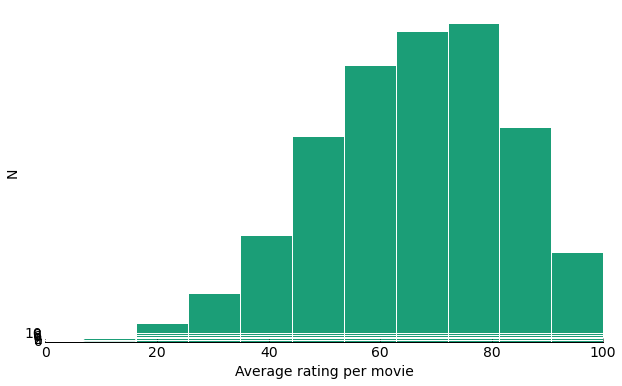

In [635]:
df = critics.copy()
df['fresh'] = (df.fresh).astype('float')
grp = df.groupby('title')
#counts = grp.critic.count()  # number of reviews by each critic

means = grp.fresh.mean()    # average freshness for each critic

means.hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per movie")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10])
histogram_style()

**2.2** What does the distribution of number of reviews per reviewer look like? Make a histogram

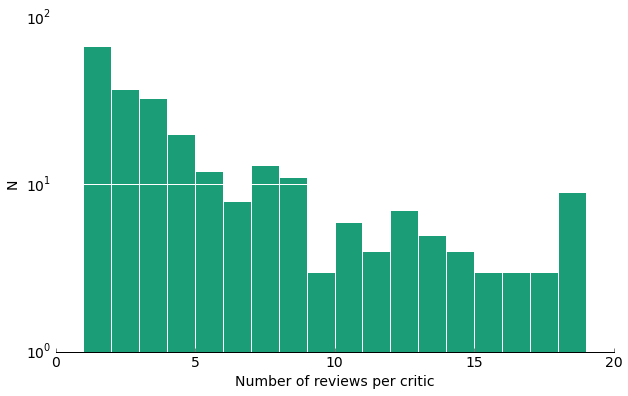

In [636]:
#Your code here


critics.groupby('critic').title.count().hist(log=True, bins=range(20), edgecolor='white')
plt.xlabel("Number of reviews per critic")
plt.ylabel("N")
histogram_style()

**2.3** List the 5 critics with the most reviews, along with the publication they write for

In [637]:
#Your code here
critics.groupby(['critic', 'publication']).title.count().order(ascending=False)[0:5]


critic              publication              
Roger Ebert         Chicago Sun-Times            1310
James Berardinelli  ReelViews                     749
Owen Gleiberman     Entertainment Weekly          626
David Sterritt      Christian Science Monitor     616
Desson Thomson      Washington Post               515
Name: title, dtype: int64

**2.4** Of the critics with > 100 reviews, plot the distribution of average "freshness" rating per critic

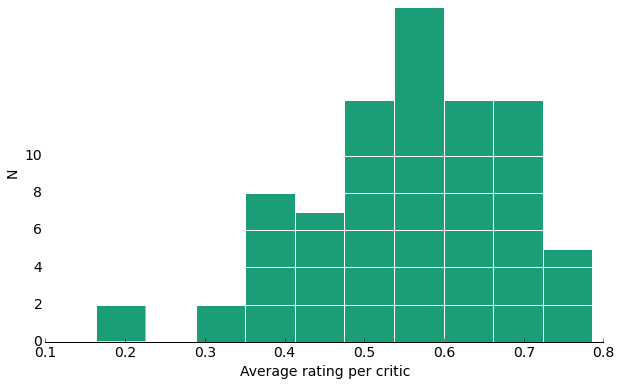

In [638]:
#Your code here
#mask=critics.groupby('critic').keys()[critics.groupby('critic').title.count()>50]
#critics.groupby('critic').title.count()>50
df = critics.copy()
critics['fresh'] = ((df.fresh).astype(int)>65)
grp = critics.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic
means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average rating per critic")
plt.ylabel("N")
plt.yticks([0, 2, 4, 6, 8, 10])
histogram_style()

**2.5**
Using the original `movies` dataframe, plot the rotten tomatoes Top Critics Rating as a function of year. Overplot the average for each year, ignoring the score=0 examples (some of these are missing data). Comment on the result -- is there a trend? What do you think it means?

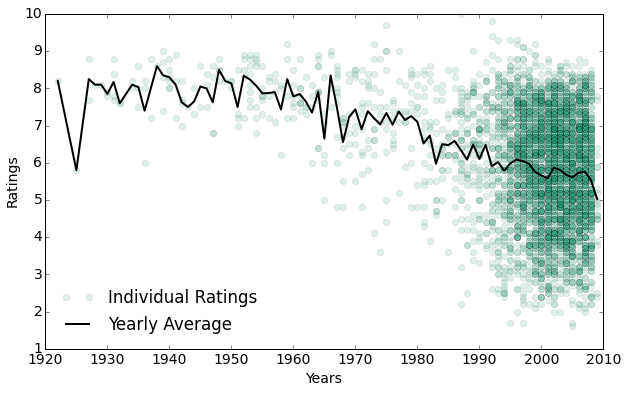

In [639]:
#Your code here


#movies_cleaned=movies[movies.rtTopCriticsRating!="\N"]
#movies_cleaned=movies_cleaned[movies_cleaned.rtTopCriticsRating>0]
data = movies[['year', 'rtTopCriticsRating']]
data = data.convert_objects(convert_numeric=True)
data = data[(data['rtTopCriticsRating'] > 0)]
means=data.groupby('year').rtTopCriticsRating.mean()
plt.plot(data.year, data.rtTopCriticsRating.astype(float),'o',alpha=0.15,label="Individual Ratings")
plt.plot(means.index,means.values,'-',c='black',label="Yearly Average")
plt.xlabel("Years")
plt.ylabel("Ratings")
plt.legend(loc='lower left',frameon=False)


*Your Comment Here*

## Part 3: Sentiment Analysis

You will now use a [Naive Bayes classifier](https://en.wikipedia.org/wiki/Naive_Bayes_classifier) to build a prediction model for whether a review is fresh or rotten, depending on the text of the review. See Lecture 9 for a discussion of Naive Bayes.

Most models work with numerical data, so we need to convert the textual collection of reviews to something numerical. A common strategy for text classification is to represent each review as a "bag of words" vector -- a long vector
of numbers encoding how many times a particular word appears in a blurb.

Scikit-learn has an object called a `CountVectorizer` that turns text into a bag of words. Here's a quick tutorial:

In [640]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print "Original text is\n", '\n'.join(text)

vectorizer = CountVectorizer(min_df=0)

# call `fit` to build the vocabulary
vectorizer.fit(text)

# call `transform` to convert text to a bag of words
x = vectorizer.transform(text)

# CountVectorizer uses a sparse array to save memory, but it's easier in this assignment to 
# convert back to a "normal" numpy array
x = x.toarray()

print
print "Transformed text vector is \n", x

# `get_feature_names` tracks which word is associated with each column of the transformed x
print
print "Words for each feature:"
print vectorizer.get_feature_names()

# Notice that the bag of words treatment doesn't preserve information about the *order* of words, 
# just their frequency

Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
[u'hop', u'off', u'on', u'pop']


**3.1**

Using the `critics` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. This will be the *input* to your model.
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output* from your model.


In [641]:
#hint: Consult the scikit-learn documentation to
#      learn about what these classes do do
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB

"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
critics : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the critics data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(critics)
"""

def make_xy(critics, vectorizer=None):
    if vectorizer==None:
        vectorizer= CountVectorizer()
    x=vectorizer.fit_transform(critics.quote).tocsc()
    y=critics.fresh.values.astype(np.int)
    return x,y
    #Your code here  vectorizer.transform(quote).toarray(),len(quote)  




In [642]:
X, Y = make_xy(critics)


**3.2** Next, randomly split the data into two groups: a
training set and a validation set. 

Use the training set to train a `MultinomialNB` classifier,
and print the accuracy of this model on the validation set

**Hint**
You can use [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) to split up the training data

In [643]:
#Your code here
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y)
clf=MultinomialNB().fit(X_train,y_train)
r_test=clf.score(X_test,y_test)
r_train=clf.score(X_train,y_train)
print "Accuracy is %0.2f%%" % (100*r_test)

Accuracy is 74.63%


**3.3:**

We say a model is **overfit** if it performs better on the training data than on the test data. Is this model overfit? If so, how much more accurate is the model on the training data compared to the test data?

In [644]:
# Your code here. Print the accuracy on the test and training dataset
print "Accuracy of training set is %0.2f%%" % (100*r_train)
print "Accuracy of test set is %0.2f%%" % (100*r_test)

Accuracy of training set is 87.52%
Accuracy of test set is 74.63%


*Interpret these numbers in a few sentences here*

**3.4: Model Calibration**

Bayesian models like the Naive Bayes classifier have the nice property that they compute probabilities of a particular classification -- the `predict_proba` and `predict_log_proba` methods of `MultinomialNB` compute these probabilities. 

Being the respectable Bayesian that you are, you should always assess whether these probabilities are **calibrated** -- that is, whether a prediction made with a confidence of `x%` is correct approximately `x%` of the time. We care about calibration because it tells us whether we can trust the probabilities computed by a model. If we can trust model probabilities, we can make better decisions using them (for example, we can calculate how much we should bet or invest in a given prediction).

Let's make a plot to assess model calibration. Schematically, we want something like this:

<img src="http://i.imgur.com/ea5B6zr.png" width=500px>

In words, we want to:

* Take a collection of examples, and compute the freshness probability for each using `clf.predict_proba`
* Gather examples into bins of similar freshness probability (the diagram shows 5 groups -- you should use something closer to 20)
* For each bin, count the number of examples in that bin, and compute the fraction of examples in the bin which are fresh
* In the upper plot, graph the expected P(Fresh) (x axis) and observed freshness fraction (Y axis). Estimate the uncertainty in observed freshness fraction $F$ via the [equation](http://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval) $\sigma = \sqrt{F (1-F) / N}$
* Overplot the line y=x. This is the trend we would expect if the model is calibrated
* In the lower plot, show the number of examples in each bin

**Hints**

The output of `clf.predict_proba(X)` is a `(N example, 2)` array. The first column gives the probability $P(Y=0)$ or  $P(Rotten)$, and the second gives $P(Y=1)$ or $P(Fresh)$.

The above image is just a guideline -- feel free to explore other options!

In [645]:
"""
Function
--------
calibration_plot

Builds a plot like the one above, from a classifier and review data

Inputs
-------
clf : Classifier object
    A MultinomialNB classifier
X : (Nexample, Nfeature) array
    The bag-of-words data
Y : (Nexample) integer array
    1 if a review is Fresh
"""    
#your code here
def calibration_plot(clf,X,Y):
    probs=clf.predict_proba(X)[:,1]
    actual=Y
    df=pd.DataFrame(dict(probs=probs,actual=actual))
    bins = np.linspace(0, 1, 20)
    #print bins
    groups = df.groupby(pd.cut(df.probs, bins))
    results=groups.agg(['mean','count'])
    results['sig']=np.sqrt((results['actual']['mean']*(1-results['actual']['mean']))/results['actual']['count'])
    fig, ax = plt.subplots(2, sharex=True)
    ax[0].errorbar(results['probs']['mean'],results['actual']['mean'],results['sig'])
    ax[0].plot(results['probs']['mean'],results['probs']['mean'])
    ax[0].set_ylabel("Observed P(Fresh)")
    ax[1].bar(bins[0:-1],height=results['actual']['count'],width=bins[1]-bins[0],edgecolor="w")
    ax[1].set_ylabel("Counts")
    ax[1].set_xlabel("P(Fresh)")
    fig.tight_layout()
    return 
#funny=calibration_plot(clf, X_test, y_test)


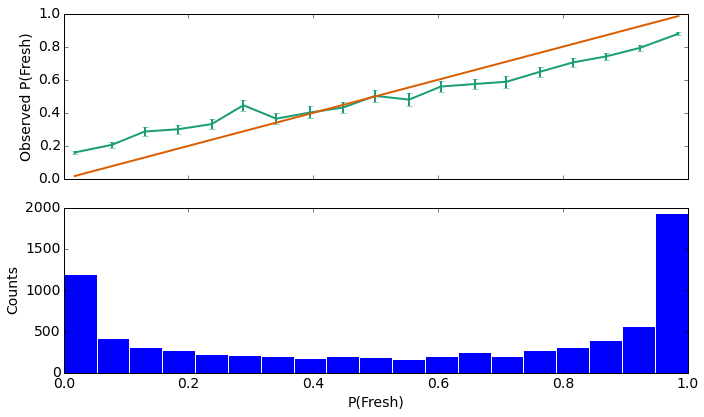

In [646]:
calibration_plot(clf, X_test, y_test)

**3.5** We might say a model is *over-confident* if the freshness fraction is usually closer to 0.5 than expected (that is, there is more uncertainty than the model predicted). Likewise, a model is *under-confident* if the probabilities are usually further away from 0.5. Is this model generally over- or under-confident? 

*Your Answer Here*

#### Cross Validation

Our classifier has a few free parameters. The two most important are:

 1. The `min_df` keyword in `CountVectorizer`, which will ignore words which appear in fewer than `min_df` fraction of reviews. Words that appear only once or twice can lead to overfitting, since words which occur only a few times might correlate very well with Fresh/Rotten reviews by chance in the training dataset.
 
 2. The [`alpha` keyword](http://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) in the Bayesian classifier is a "smoothing parameter" -- increasing the value decreases the sensitivity to any single feature, and tends to pull prediction probabilities closer to 50%. 

As discussed in lecture and HW2, a common technique for choosing appropriate values for these parameters is **cross-validation**. Let's choose good parameters by maximizing the cross-validated log-likelihood.

**3.6** Using `clf.predict_log_proba`, write a function that computes the log-likelihood of a dataset

In [647]:
"""
Function
--------
log_likelihood

Compute the log likelihood of a dataset according to a bayesian classifier. 
The Log Likelihood is defined by

L = Sum_fresh(logP(fresh)) + Sum_rotten(logP(rotten))

Where Sum_fresh indicates a sum over all fresh reviews, 
and Sum_rotten indicates a sum over rotten reviews
    
Parameters
----------
clf : Bayesian classifier
x : (nexample, nfeature) array
    The input data
y : (nexample) integer array
    Whether each review is Fresh
"""
#your code here
def log_likelihood(clf,x,y):
    probs=clf.predict_log_proba(x)
    df=pd.DataFrame(dict(rotten=probs[:,0],fresh=probs[:,1],actual=y))
    grouped=df.groupby('actual').sum()
    return grouped['fresh'][1]+grouped['rotten'][0]



Here's a function to estimate the cross-validated value of a scoring function, given a classifier and data

In [648]:
from sklearn.cross_validation import KFold

def cv_score(clf, x, y, score_func):
    """
    Uses 5-fold cross validation to estimate a score of a classifier
    
    Inputs
    ------
    clf : Classifier object
    x : Input feature vector
    y : Input class labels
    score_func : Function like log_likelihood, that takes (clf, x, y) as input,
                 and returns a score
                 
    Returns
    -------
    The average score obtained by randomly splitting (x, y) into training and 
    test sets, fitting on the training set, and evaluating score_func on the test set
    
    Examples
    cv_score(clf, x, y, log_likelihood)
    """
    result = 0
    nfold = 5
    for train, test in KFold(y.size, nfold): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf, x[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

# as a side note, this function is builtin to the newest version of sklearn. We could just write
# sklearn.cross_validation.cross_val_score(clf, x, y, scorer=log_likelihood).

**3.7**

Fill in the remaining code in this block, to loop over many values of `alpha` and `min_df` to determine
which settings are "best" in the sense of maximizing the cross-validated log-likelihood

In [649]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
max_loglike = -np.inf

for alpha in alphas:
    for min_df in min_dfs:         
        vectorizer = CountVectorizer(min_df = min_df)       
        X, Y = make_xy(critics, vectorizer)
        
        clf = MultinomialNB(alpha=alpha)
        score = cv_score(clf, X, Y, log_likelihood)

        if score > max_loglike:
            max_loglike = score
            best_alpha, best_min_df = alpha, min_df
        #your code here


In [650]:
print "alpha: %f" % best_alpha
print "min_df: %f" % best_min_df

alpha: 10.000000
min_df: 0.001000


**3.8** Now that you've determined values for alpha and min_df that optimize the cross-validated log-likelihood, repeat the steps in 3.1, 3.2, and 3.4 to train a final classifier with these parameters, re-evaluate the accuracy, and draw a new calibration plot.

Accuracy of training set: 0.74
Accuracy of test set:     0.72


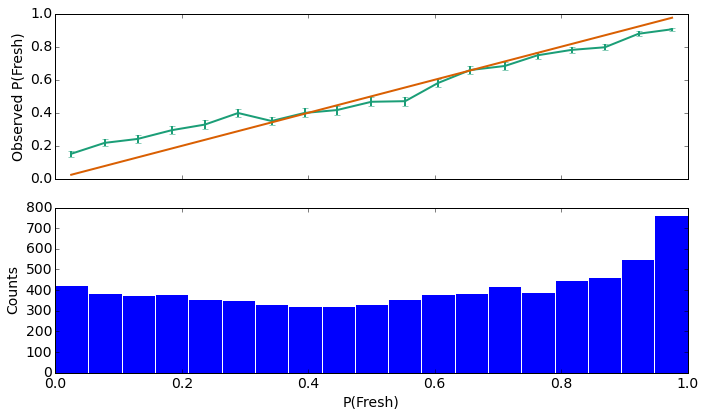

In [651]:
#Your code here
vectorizer = CountVectorizer(min_df=best_min_df)
X, Y = make_xy(critics, vectorizer)
X_train, X_test, y_train, y_test = train_test_split(X, Y)

clf = MultinomialNB(alpha=best_alpha).fit(X_train, y_train)

calibration_plot(clf, X_test, y_test)

# Your code here. Print the accuracy on the test and training dataset
training_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)

print "Accuracy of training set: %0.2f" % (training_accuracy)
print "Accuracy of test set:     %0.2f" % (test_accuracy)

**3.9** Discuss the various ways in which Cross-Validation has affected the model. Is the new model more or less accurate? Is overfitting better or worse? Is the model more or less calibrated?

*Your Answer Here*

*To think about/play with, but not to hand in: What would happen if you tried this again using a function besides the log-likelihood -- for example, the classification accuracy?*

## Part 4: Interpretation. What words best predict a fresh or rotten review?

**4.1**
Using your classifier and the `vectorizer.get_feature_names` method, determine which words best predict a positive or negative review. Print the 10 words
that best predict a "fresh" review, and the 10 words that best predict a "rotten" review. For each word, what is the model's probability of freshness if the word appears one time?

#### Hints

* Try computing the classification probability for a feature vector which consists of all 0s, except for a single 1. What does this probability refer to?

* `np.eye` generates a matrix where the ith row is all 0s, except for the ith column which is 1.

In [652]:
# Your code here
words=np.array(vectorizer.get_feature_names())
ind_words=np.eye(X_test.shape[1])
probs=clf.predict_proba(ind_words)[:,1]
index = np.argsort(probs)

good_words = words[index[-10:]]
bad_words = words[index[:10]]

good_prob = probs[index[-10:]]
bad_prob = probs[index[:10]]

print "Good words\t     P(fresh | word)"
for w, p in zip(good_words, good_prob):
    print "%20s" % w, "%0.2f" % p
    
print "Bad words\t     P(fresh | word)"
for w, p in zip(bad_words, bad_prob):
    print "%20s" % w, "%0.2f" % p

Good words	     P(fresh | word)
            gripping 0.80
             crafted 0.80
         devastating 0.81
             delight 0.81
          remarkable 0.81
        exhilarating 0.82
         wonderfully 0.82
         brilliantly 0.83
                rare 0.83
         masterpiece 0.83
Bad words	     P(fresh | word)
       unfortunately 0.17
                lame 0.17
            mediocre 0.20
           pointless 0.21
                mess 0.21
              excuse 0.22
                dull 0.22
          uninspired 0.22
               worst 0.23
                dumb 0.23


**4.2**

One of the best sources for inspiration when trying to improve a model is to look at examples where the model performs poorly. 

Find 5 fresh and rotten reviews where your model performs particularly poorly. Print each review.

In [653]:
#Your code here
x,y=make_xy(critics,vectorizer)
probs=clf.predict_proba(x)[:,1]
#probs_good=probs[:,1]
#robs_bad=probs[:,0]

ind_good=np.argsort(probs[y==1])
ind_bad=np.argsort(probs[y==0])

print "Fresh reviews gone bad\n"
for row in ind_good[0:5]:
    print critics.quote[row], probs[ind[row]] ,"\n"
#print critics.quote[ind[-1]],probs[ind[-1]]

print "Bad reviews my foot\n"
for row in ind_bad[-5:]:
    print critics.quote[row],probs[ind[row]],"\n"

Fresh reviews gone bad

The most lethal weapon of all turns out to be the script. 0.338410461954 

Schlesinger, working from a script by Malcolm Bradbury, maintains a steady rhythm and a light, cheerful mood that seem to reflect the brisk sanity of the heroine. 0.119663388879 

De Bont and his team have turned in a visually sophisticated piece of mayhem that makes the implausible plausible and keeps the thrills coming. [10Jun1994 Pg. F1] 0.0674058338522 

Unstrung Heroes is an extremely moving and surprisingly funny love sonnet to family, tolerance and the joys of individuality.... One of the best films of the year. [15 Sep 1995] 0.03908122013 

One of the great movie satires. And if it isn't the funniest rock spoof ever made, it certainly shares the title with "The Rutles." 0.102776527632 

Bad reviews my foot

A revealing, heart- and mind-engaging insight into a uniquely American character type many of us may have known. 0.422671160889 

On its own good-natured terms, Selena' is both

**4.3** What do you notice about these mis-predictions? Naive Bayes classifiers assume that every word affects the probability independently of other words. In what way is this a bad assumption? In your answer, report your classifier's Freshness probability for the review "This movie is not remarkable, touching, or superb in any way".

In [654]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

array([[ 0.04621718,  0.95378282]])

**4.4**
If this was your final project, what are 3 things you would try in order to build a more effective review classifier? What other exploratory or explanatory visualizations do you think might be helpful?

*Your answer here*

### How to Submit

Restart and run your notebook one last time, to make sure the output from each cell is up to date. To submit your homework, create a folder named lastname_firstinitial_hw3 and place your solutions in the folder. Double check that the file is still called HW3.ipynb, and that it contains your code. Please do **not** include the critics.csv data file, if you created one. Compress the folder (please use .zip compression) and submit to the CS109 dropbox in the appropriate folder. If we cannot access your work because these directions are not followed correctly, we will not grade your work!

---
*css tweaks in this cell*
<style>
div.text_cell_render {
    line-height: 150%;
    font-size: 110%;
    width: 800px;
    margin-left:50px;
    margin-right:auto;
    }
</style>